In [487]:
import numpy as np
import sys
import matplotlib.pylab as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

In [227]:
def make_generator_matrix(H):
    cH = H.copy()
    cH = cH.astype(int)
    ind = []
    for i in range(cH.shape[1]):
        cur_row = len(ind)
        nzind = np.nonzero(cH[:, i])[0]
        nzind = nzind[nzind >= cur_row]
        if nzind.shape[0] == 0:
            continue

        if nzind[0] > cur_row:
            cH[[cur_row, nzind[0]], :] = cH[[nzind[0], cur_row], :]
        cH[nzind[1:],:] = np.bitwise_xor(cH[nzind[1:], :], cH[cur_row, :][np.newaxis, :])
        ind.append(i)
        if len(ind) == cH.shape[0]:
            break
            
    if len(ind) < cH.shape[0]:
        raise ValueError('low rank of matrix H')
    
    for i in range(cH.shape[0] - 1, 0, -1):
        nzind = np.nonzero(cH[:i, ind[i]])[0]
        if nzind.shape[0] == 0:
            continue
        cH[nzind, :] = np.bitwise_xor(cH[nzind, :], cH[i, :][np.newaxis, :])
        
    G = np.zeros((cH.shape[1], cH.shape[1] - cH.shape[0]), dtype=int)
    ind_mask= np.in1d(np.arange(cH.shape[1]), ind)
    non_ind_mask = np.logical_not(ind_mask)
    G[ind_mask] = cH[:, non_ind_mask]
    G[non_ind_mask] = np.eye(G.shape[1])
    
    ind = np.arange(G.shape[0])[non_ind_mask]
    return G, ind

In [736]:
def make_check_matrix(size):
    while True:
        print("just one attempt")
        H = np.zeros(size, dtype=int)
        for i in range(H.shape[1]):
            ind = np.random.choice(H.shape[0], size=3, replace=False)
            H[ind, i] = 1
        
        for j in range(H.shape[0]):
            ind = np.random.choice(H.shape[1], size=3, replace=False)
            H[j, ind] = 1
#         H = np.random.random(size)
#         H = H < q
#         H = H.astype(int)  
        if (np.sum(H, axis=0) < 2).any():
            print("bad config")
            continue
        if (np.sum(H, axis=1) < 2).any():
            print("bad config")
            continue
        try:
            make_generator_matrix(H)
        except ValueError:
            continue
        break
    return H

In [632]:
np.random.choice(5, size=3, replace=False)

array([1, 2, 3])

In [782]:
def message_from_factor(H, mu_e_h, i, j, sj):
    index = H[j, :].copy().astype(bool)
    index[i] = False
#     if np.sum(index) == 0:
#         return [1/2, 1/2]
    dp = mu_e_h[index, j, 0] - mu_e_h[index, j, 1]
    dp = np.prod(dp)
#     if 1/2 * (1 + dp - 2 * sj * dp) < 0 or 1/2 * (1 - dp + 2 * sj * dp):
#         print(sj)
#         print(dp)
#         raise ValueError("big dp")
    return np.array([1/2 * (1 + dp - 2 * sj * dp), 1/2 * (1 - dp + 2 * sj * dp)])
    
        
def message_from_node(H, mu_h_e, i, j, q):
    index = H[:, i].copy().astype(bool)
    index[j] = False
    ans = np.prod(mu_h_e[index, i], axis=0)
    ans *= [1 - q, q]
    ans /= np.sum(ans)
    return ans

In [719]:
def decode(s, H, q, schedule = 'parallel', damping = 1, max_iter = 300, tol_beliefs = 1e-4, display = False):
    mu_e_h = np.ones((H.shape[1], H.shape[0], 2)) 
    mu_h_e = np.ones((H.shape[0], H.shape[1], 2))
    b = np.ones((H.shape[1], 2))
    
#     mu_e_h[:, :, 1] = q
    mu_e_h[:, :, 1] *= 0.5 * q  + 0.5 * np.random.random(mu_e_h.shape[0:2])
    mu_e_h[:, :, 0] = 1 - mu_e_h[:, :, 1]
    
    rate_belief = [] 
    for it in range(max_iter):
        if schedule == 'parallel':
            factor_node = np.array(np.nonzero(H)).T
            for j, i in factor_node:
                mu = message_from_factor(H, mu_e_h, i, j, s[j])
                mu_h_e[j, i] = mu * damping + mu_h_e[j, i] * (1 - damping)
            
            for j, i in factor_node:
                mu = message_from_node(H, mu_h_e, i, j, q)
                mu_e_h[i, j] = mu * damping + mu_e_h[i, j] * (1 - damping)    
        elif schedule == 'sequential':
            for i in range(H.shape[1]):
                factor_ind = np.nonzero(H[:, i])[0]
                for j in factor_ind:
                    mu = message_from_factor(H, mu_e_h, i, j, s[j])
                    mu_h_e[j, i] = mu * damping + mu_h_e[j, i] * (1 - damping)
                
                for j in factor_ind:
                    mu = message_from_node(H, mu_h_e, i, j, q)
                    mu_e_h[i, j] = mu * damping + mu_e_h[i, j] * (1 - damping)
        else:
            raise ValueError('wrong name of schedule')
                    
        b_old = b.copy()
        copy_mu_h_e = mu_h_e.copy()
        copy_mu_h_e[H == 0] = 1
        
        b =  np.prod(copy_mu_h_e, axis=0)
        b[:, 0] *= 1 - q
        b[:, 1] *= q
        b /= np.sum(b, axis=1)[:, np.newaxis]
        
        e = np.argmax(b, axis=1)
        dist = np.max(np.abs(b - b_old))
            
        if display:
            print(it + 1, "iteration", np.mean(np.abs(b - b_old) < tol_beliefs))
            sys.stdout.flush()
        if np.array_equal(np.dot(H, e) % 2, s):
            return e, 0
        if dist < tol_beliefs:
            return e, 1
    return e, 2

In [730]:
def experiment_decode(s, H, q, schedule = 'parallel', damping = 1, max_iter = 300, tol_beliefs = 1e-4, 
                      display = False, calc_belief=True):
    mu_e_h = np.ones((H.shape[1], H.shape[0], 2)) 
    mu_h_e = np.ones((H.shape[0], H.shape[1], 2))
    b = np.ones((H.shape[1], 2))
    
#     mu_e_h[:, :, 1] = q
    mu_e_h[:, :, 1] *= 0.5 * q  + 0.5 * np.random.random(mu_e_h.shape[0:2])
    mu_e_h[:, :, 0] = 1 - mu_e_h[:, :, 1]
    
    list_belief = []
    list_e = []
    for it in range(max_iter):
        if schedule == 'parallel':
            factor_node = np.array(np.nonzero(H)).T
            for j, i in factor_node:
                mu = message_from_factor(H, mu_e_h, i, j, s[j])
                mu_h_e[j, i] = mu * damping + mu_h_e[j, i] * (1 - damping)
            
            for j, i in factor_node:
                mu = message_from_node(H, mu_h_e, i, j, q)
                mu_e_h[i, j] = mu * damping + mu_e_h[i, j] * (1 - damping)    
        elif schedule == 'sequential':
            for i in range(H.shape[1]):
                factor_ind = np.nonzero(H[:, i])[0]
                for j in factor_ind:
                    mu = message_from_factor(H, mu_e_h, i, j, s[j])
                    mu_h_e[j, i] = mu * damping + mu_h_e[j, i] * (1 - damping)
                
                for j in factor_ind:
                    mu = message_from_node(H, mu_h_e, i, j, q)
                    mu_e_h[i, j] = mu * damping + mu_e_h[i, j] * (1 - damping)
        else:
            raise ValueError('wrong name of schedule')
                    
        b_old = b.copy()
        copy_mu_h_e = mu_h_e.copy()
        copy_mu_h_e[H == 0] = 1
        
        b =  np.prod(copy_mu_h_e, axis=0)
        b[:, 0] *= 1 - q
        b[:, 1] *= q
        b /= np.sum(b, axis=1)[:, np.newaxis]
        
        e = np.argmax(b, axis=1)
        list_e.append(e)
        belief_rate = np.mean(np.abs(b - b_old) < tol_beliefs)
        if calc_belief:
            list_belief.append(belief_rate)
        
        if display:
            print(it + 1, "iteration", belief_rate)
            sys.stdout.flush()
            
        if np.array_equal(np.dot(H, e) % 2, s):
            return list_e, 0, list_belief
        if np.max(np.abs(b - b_old)) < tol_beliefs:
            return list_e, 1, list_belief
    return list_e, 2, list_belief

In [663]:
H = make_check_matrix([15, 25])
G, ind = make_generator_matrix(H)
print(H)
print(G)
print(ind)
print(np.dot(H, G) % 2)
print(G[ind, :])

just one attempt
[[0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0]
 [0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0]
 [0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0]
 [1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1]
 [1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0]
 [0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1]
 [0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0]]
[[1 0 1 0 1 1 0 1 1 1]
 [1 0 1 0 0 0 0 1 0 1]
 [1 0 1 0 1 1 0 0 0 1]
 [0 1 0 0 0 0 1 1 0 0]
 [0 0 1 1 0 0 0 0 0 1]
 [0 1 0 0 0 1 1 0 0 0]
 [1 0 1 0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0

In [416]:
a = np.random.randint(0, 2, G.shape[1])
print(a)
a_code = np.dot(G, a) % 2

q = 0.1
index = np.random.random(a_code.shape[0]) < q
# index = np.random.randint(0, a_code.shape[0])
a_get = a_code.copy()
print(a_get)
a_get[index] = np.logical_not(a_get[index]).astype(int)
print(a_get)
s = np.dot(H, a_get) % 2
print(s)
print(index)

[0 1 0 1 1]
[0 0 0 1 1 1 1 0 0 1 0 1 0 1 1]
[0 0 0 1 0 1 1 1 0 0 1 1 0 1 1]
[0 0 1 1 0 1 0 0 0 0]
[False False False False  True False False  True False  True  True False
 False False False]


In [426]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='/home/george/Documents/GM/').data

In [438]:
side = int(np.sqrt(mnist.shape[1]))
pic = mnist[20000].reshape(side, side)
pic = (pic>0).astype(int).ravel()
# plt.imshow(pic)

In [453]:
print(pic.dtype)
print(new_pic.dtype)

int64
int64


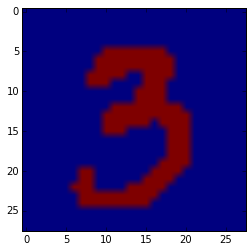

In [460]:
plt.imshow(pic.reshape(side, side))
plt.show()


In [749]:
k = pic.shape[0]
n = 5 * k
m = 4 * k

In [765]:
H = make_check_matrix([m, n])
G, ind = make_generator_matrix(H)

just one attempt


In [766]:
np.sum(H)/H.shape[1]

5.3974489795918368

In [767]:
pic_code = np.dot(G, pic) % 2

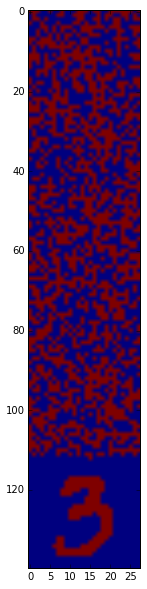

In [768]:
plt.imshow(pic_code.reshape(-1, side))

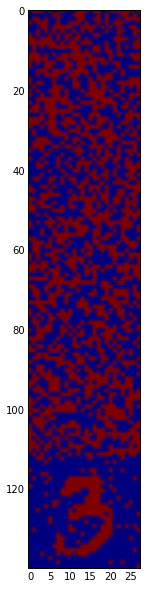

In [779]:
q = 0.08
get_pic = (pic_code + (np.random.random(pic_code.shape) < q).astype(int)) % 2
plt.imshow(get_pic.reshape(-1, side))

In [548]:
def pass_ability_channel(q):
    return 1 + q * np.log(q) + (1 - q) * np.log(1 - q)
pass_ability_channel(0.02)

In [714]:
np.equal(pic_code, (get_pic + e) % 2).all()

True

In [785]:
s  = np.dot(H, get_pic) % 2
e, status = decode(s, H, 0.08, max_iter=25, damping=0.8, schedule='parallel', display=True)
print(status)

1 iteration 0.0
2 iteration 0.000765306122449
3 iteration 0.000510204081633
4 iteration 0.00765306122449
5 iteration 0.0798469387755
6 iteration 0.238775510204
7 iteration 0.470918367347
8 iteration 0.739795918367
0


In [731]:
s = np.dot(H, get_pic) % 2
list_e, status, list_belief =  experiment_decode(s, H, 0.03, max_iter=25, schedule='sequential', display=True)

1 iteration 0.0168367346939
2 iteration 0.030612244898
3 iteration 0.285714285714
4 iteration 0.580867346939
5 iteration 0.886479591837
6 iteration 0.997193877551


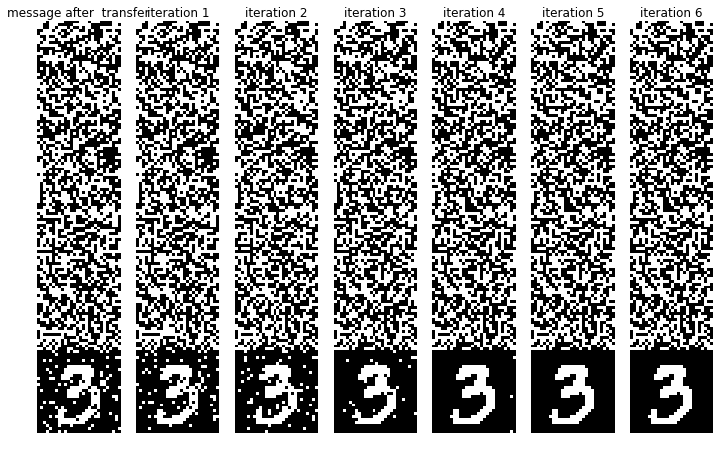

In [732]:
fig, a = plt.subplots(nrows=1, ncols=len(list_e) + 1)
fig.subplots_adjust(right=2.0)

a[0].imshow(get_pic.reshape(-1, side), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
a[0].set_title("message after  transfer")
a[0].axis('off')
for i, e in enumerate(list_e):
    a[i + 1].imshow(((get_pic + list_e[i]) % 2).reshape(-1, side),cmap='gray', 
                    vmin=0, vmax=1, interpolation='nearest')
    a[i + 1].set_title("iteration " +str(i + 1))
    a[i + 1].axis('off')
# plt.imshow( ((get_pic + list_e[2]) % 2).reshape(-1, side))

## Пункт 3

In [743]:
import time

In [735]:
k

784

In [741]:
def point3(H, G, q, num_iter,  schedule, list_damping, max_iter):
    max_iter = 25
    rate_belief = np.zeros((len(list_damping), max_iter))
    t = np.zeros(len(list_damping))
    k = G.shape[1]
      
    sum_status = 0
    for it in range(num_iter):
        word = np.random.randint(0, 2, size=k)
        message = np.dot(G, word)
        get_message = (message + (np.random.random(message.shape) < q).astype(int)) % 2
        s  = np.dot(H, get_message) % 2
        
        for i, damping in enumerate(list_damping):
            start_time = time.time()
            list_e, status, list_belief = experiment_decode(s, H, q, max_iter=max_iter, 
                                                                damping=damping, schedule=schedule)
            t[i] += time.time() - start_time
            rate_belief[i][:len(list_belief)] += list_belief 
            sum_status += status
        print('iteration', it + 1, sum_status)
        sys.stdout.flush()
    rate_belief /= num_iter
    return rate_belief, t

In [810]:
k = 100
n = 500

m = n - k
H = make_check_matrix([m, n])
G, ind = make_generator_matrix(H)

just one attempt


In [820]:
list_damping = [0.5, 0.9, 1]
rate_belief, t = point3(H, G, 0.08, 2, 'parallel', list_damping, 30)

iteration 1 0
iteration 2 0


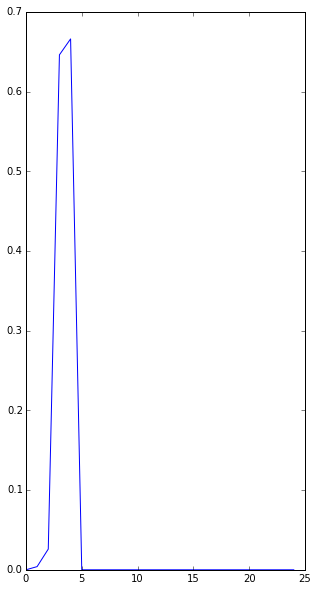

In [823]:
plt.plot(rate_belief[2])

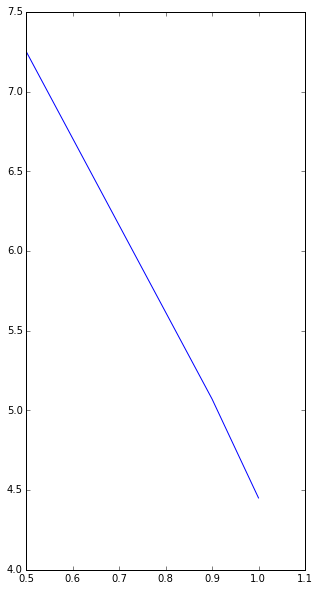

In [813]:
plt.plot(list_damping, t)

### Пункт 4

In [855]:
def estimate_errors(H, q, num_points = 200):
    k = H.shape[1] - H.shape[0]
    diver = 0
    err_bit = 0
    err_block = 0
    for it in range(num_points):
        word = np.random.randint(0, 2, size=k)
        message = np.dot(G, word)
        channel_e = (np.random.random(message.shape) < q).astype(int)
        channel_message = (message + channel_e) % 2
        s  = np.dot(H, channel_message) % 2
        e, status = decode(s, H, q, max_iter=40, schedule='sequential')
        
        if status == 2:
            diver += 1
        else:
            err_bit += not np.array_equal(e, channel_e)
            err_block += np.mean(np.abs(e - channel_e))
#         print('iteration', it)
#         sys.stdout.flush()
    
    if num_points == diver:
        err_bit = 1
        err_block = 1
    else:
        err_bit /= num_points - diver
        err_block /= num_points - diver
    diver /= num_points
    return err_bit, err_block, diver    

In [853]:
q_list = 0.01 * (np.arange(20) + 1)
print(q)
# q_list = [0.01]

0.2


In [856]:
err_bit_list = []
err_block_list = []
diver_list = []
for i, q in enumerate(q_list):
    err_bit, err_block, diver = estimate_errors(H, 0.1, num_points = 10)
    err_bit_list.append(err_bit)
    err_block_list.append(err_block)
    diver_list.append(diver)
    print('iteration', i)
    sys.stdout.flush()

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19


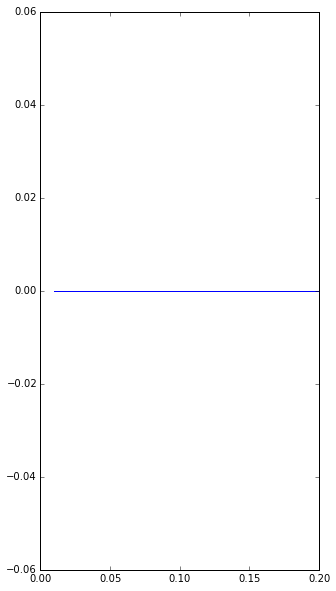

In [857]:
plt.plot(q_list, err_bit_list)

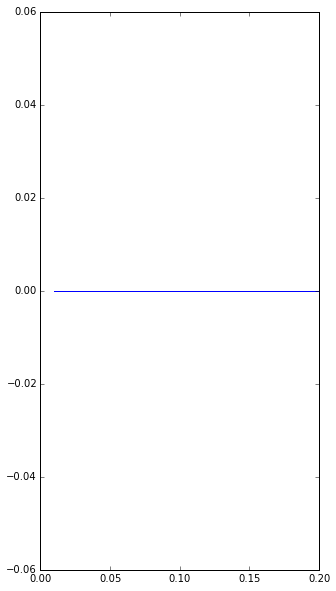

In [858]:
plt.plot(q_list, err_block_list)

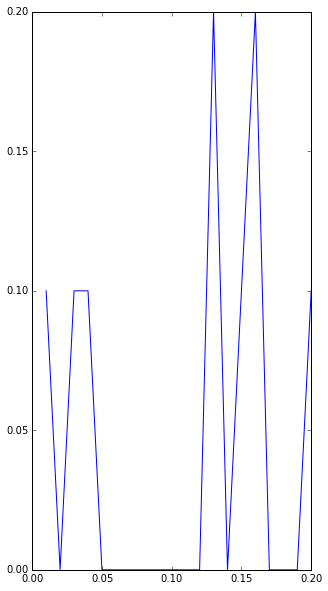

In [859]:
plt.plot(q_list, diver_list)

In [829]:
err_bit

0.0

In [332]:
np.dot(H, e + a_get) % 2

array([0, 0, 0, 0, 0, 0, 0])

In [333]:
np.dot(H, a_code) % 2

array([0, 0, 0, 0, 0, 0, 0])

[1 1 0 0 1 1 1 0 1 1 0 0 0 0 1] [1 1 0 0 1]
[1 1 0 0 1 1 1 0 1 1 0 0 0 0 1] [1 1 0 0 1]


In [267]:
mu_e_h = np.ones((H.shape[1], H.shape[0], 2)) 
mu_h_e = np.ones((H.shape[0], H.shape[1], 2))
b = np.ones((H.shape[1], 2))

mu_e_h[:, :, 1] = q
mu_e_h[:, :, 1] *= 0.5 * q  + 0.5 * np.random.random(mu_e_h.shape[0:2])
mu_e_h[:, :, 0] *= 1 - mu_e_h[:, :, 1]

In [268]:
mu_e_h

array([[[ 0.97925379,  0.02074621],
        [ 0.99423137,  0.00576863],
        [ 0.96532368,  0.03467632],
        [ 0.98406498,  0.01593502],
        [ 0.94700574,  0.05299426],
        [ 0.9569488 ,  0.0430512 ],
        [ 0.94585431,  0.05414569]],

       [[ 0.96564415,  0.03435585],
        [ 0.98588613,  0.01411387],
        [ 0.98332086,  0.01667914],
        [ 0.98929791,  0.01070209],
        [ 0.99349409,  0.00650591],
        [ 0.96753875,  0.03246125],
        [ 0.95650721,  0.04349279]],

       [[ 0.95501598,  0.04498402],
        [ 0.95855298,  0.04144702],
        [ 0.95131673,  0.04868327],
        [ 0.94672379,  0.05327621],
        [ 0.94512225,  0.05487775],
        [ 0.9520082 ,  0.0479918 ],
        [ 0.99461351,  0.00538649]],

       [[ 0.95661067,  0.04338933],
        [ 0.96484433,  0.03515567],
        [ 0.9515073 ,  0.0484927 ],
        [ 0.95947959,  0.04052041],
        [ 0.98725597,  0.01274403],
        [ 0.95703926,  0.04296074],
        [ 0.98554276, 

In [196]:
mu_h_e, mu_e_h = decode(s, H, q)

In [171]:
mu_e_h[3, 1]

array([ 0.55007017,  0.44992983])

In [245]:
e

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [241]:
status

1

In [148]:
status

0

In [142]:
a = np.ones((5,3))
b = np.ones((5, 3))
print(np.equal(a, b))

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [132]:
c = 5 * np.random.random((5, 5, 2))
c /= np.sum(c, axis=2)[:, :, np.newaxis]
print(c[2, 1])

[ 0.13588154  0.86411846]


In [96]:
s = np.dot(H, a_get)

In [95]:
index

array([False, False, False, False,  True, False, False, False, False], dtype=bool)

In [56]:
print(a)
np.logical_not(a)

[1 0 1 0 0]


array([False,  True, False,  True,  True], dtype=bool)

In [177]:
H

array([[0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0]])

In [30]:
a = np.array([
        [1, 2, 3],
        [2, 1, 0]
    ])
print(np.argmax(a, axis=0))

[1 0 0]


In [28]:
H = np.array([[0, 0, 0, 0, 1],
       [1, 0, 1, 1, 0],
       [0, 1, 1, 1, 1]])
H[H[:,1]== 0] = 0
print(H)
for i,j in np.array(np.nonzero(H)).T:
    print(i, j)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 1]]
2 1
2 2
2 3
2 4


In [79]:
np.in1d(7, np.array([1, 3]))

array([False], dtype=bool)

In [19]:
H = np.array([
        [1, 1, 0, 1, 1],
        [0, 0, 0, 1, 0],
        [1, 1, 1, 0, 0]
    ], dtype=int)

In [39]:
H[0:2]

array([[1, 1, 0, 1, 1],
       [0, 0, 0, 1, 0]])

In [111]:
G, ind = make_generator_matrix(H)
print(G)
print(ind)
print(np.dot(H, G) % 2 )

[[1 1]
 [1 0]
 [0 1]
 [0 0]
 [0 1]]
[0, 2, 3]
[[0 0]
 [0 0]
 [0 0]]


In [57]:
print(G)
print(ind)

[[1 1 0 0 1]
 [0 0 1 0 1]
 [0 0 1 1 1]]
[0, 2, 3]


In [3]:
a = np.array([0,0,0,1])
print(np.nonzero(a))

(array([3]),)


In [37]:
a = np.arange(10)
for i in range(5, 0, -1):
    print(i)

5
4
3
2
1
